In [1]:
!pip install spotipy
!pip install gradio
!pip install opencv-python
!pip install PyQt5
!pip install flask

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pickle
import os
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

✅ 총 학습 이미지 수: 1056   레이블 수: 1056


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Epoch 1/5] Train Loss: 1.3701, Acc: 0.5308  |  Val Loss: 0.9266, Acc: 0.7123
[Epoch 2/5] Train Loss: 0.7266, Acc: 0.7216  |  Val Loss: 0.5926, Acc: 0.7547
[Epoch 3/5] Train Loss: 0.5420, Acc: 0.8128  |  Val Loss: 0.4740, Acc: 0.7972
[Epoch 4/5] Train Loss: 0.4746, Acc: 0.7986  |  Val Loss: 0.6075, Acc: 0.7689
[Epoch 5/5] Train Loss: 0.3225, Acc: 0.8472  |  Val Loss: 0.3129, Acc: 0.8255
✅ 학습 완료 및 cnn_model_re.pt 저장됨


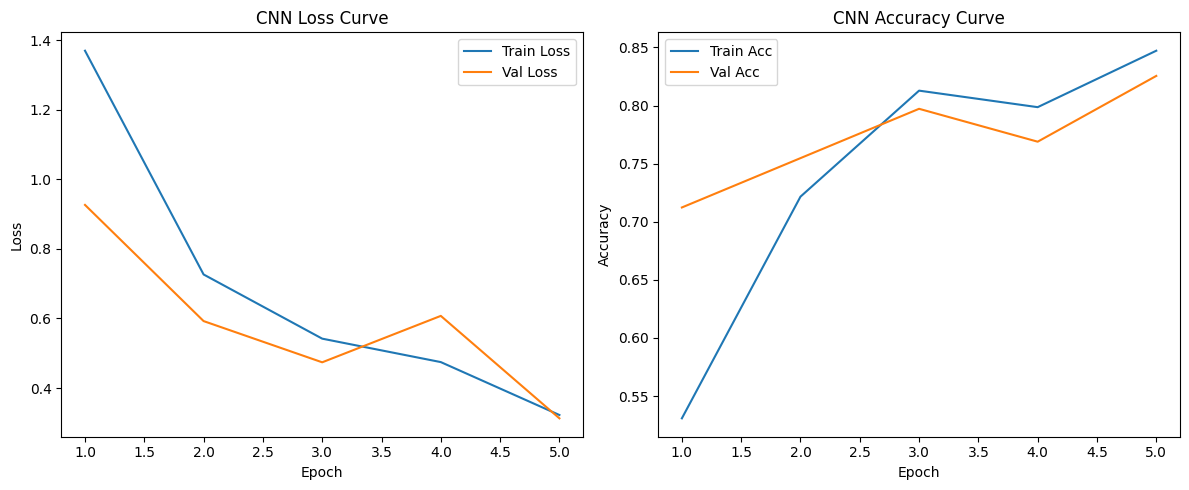

In [28]:
# 셀 2: 데이터셋 정의 + CNN 학습 및 저장  (수정본)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pickle
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# (1) Dataset 클래스 정의 (파일 입출력 오류 방지용 수정 포함)
class OSTImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        lbl = self.labels[idx]
        try:
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)
        except Exception as e:
            print(f"⚠️ 이미지 로드 실패: {img_path}  → {e}")
            blank = Image.new("RGB", (224,224), (0,0,0))
            img = self.transform(blank)
        return img, torch.tensor(lbl, dtype=torch.long)

# (2) 라벨 인코더 로드
label_encoder_path = "label_encoder.pkl"
if not os.path.exists(label_encoder_path):
    raise FileNotFoundError(f"라벨 인코더 파일이 없습니다: {label_encoder_path}")
with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)
num_labels = len(label_encoder.classes_)

# (3) 학습용 이미지 경로 + 라벨 리스트 준비
image_dir = "video_frames2"
all_paths, all_labels = [], []
for lbl_name in label_encoder.classes_:
    lbl_idx = int(label_encoder.transform([lbl_name])[0])
    subdir = os.path.join(image_dir, str(lbl_idx))
    if not os.path.isdir(subdir):
        continue
    for fname in os.listdir(subdir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            full_path = os.path.join(subdir, fname)
            if os.path.isfile(full_path):
                all_paths.append(full_path)
                all_labels.append(lbl_idx)
print(f"✅ 총 학습 이미지 수: {len(all_paths)}   레이블 수: {len(all_labels)}")

# (4) 학습/검증 분리
train_paths, val_paths, train_lbls, val_lbls = train_test_split(
    all_paths, all_labels,
    test_size=0.2,
    random_state=42,
    stratify=all_labels
)

# (5) 이미지 전처리 정의
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# (6) Dataset/Dataloader 생성 (num_workers=0 으로 설정)
train_dataset = OSTImageDataset(train_paths, train_lbls, image_transform)
val_dataset   = OSTImageDataset(val_paths,   val_lbls,   image_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# (7) CNN 모델 정의
class CNNClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CNNClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_labels)
    def forward(self, x):
        return self.backbone(x)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
cnn_model = CNNClassifier(num_labels=num_labels).to(DEVICE)

# (8) 학습 세팅
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# (9) 학습 함수 정의 (손실 + 정확도 기록)
def train_cnn(model, train_loader, val_loader, epochs=10):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = total_correct = total_samples = 0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += images.size(0)
        train_loss = running_loss / total_samples
        train_acc  = total_correct / total_samples
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_running_loss = val_correct = val_samples = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_samples += images.size(0)
        val_loss = val_running_loss / val_samples
        val_acc  = val_correct / val_samples
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"[Epoch {epoch}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}  |  "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    torch.save(model.state_dict(), "cnn_model_re.pt")
    print("✅ 학습 완료 및 cnn_model_re.pt 저장됨")
    return train_losses, val_losses, train_accs, val_accs

# (10) 학습 실행
train_losses, val_losses, train_accs, val_accs = train_cnn(cnn_model, train_loader, val_loader, epochs=5)

# (11) 학습 곡선 시각화 (손실 & 정확도)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1,len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1,len(val_losses)+1),   val_losses,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('CNN Loss Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(train_accs)+1), train_accs, label='Train Acc')
plt.plot(range(1,len(val_accs)+1),   val_accs,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('CNN Accuracy Curve'); plt.legend()

plt.tight_layout()
plt.show()

In [3]:
label_encoder_path = "label_encoder.pkl"
cnn_model_path      = "cnn_model_re.pt"

if not os.path.exists(label_encoder_path):
    raise FileNotFoundError(f"라벨 인코더 파일이 없습니다: {label_encoder_path}")
if not os.path.exists(cnn_model_path):
    raise FileNotFoundError(f"CNN 모델 파일이 없습니다: {cnn_model_path}")

with open(label_encoder_path, "rb") as f:
    label_encoder = pickle.load(f)

# 디바이스 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# CNN 모델 클래스 정의 (학습 시 사용한 것과 동일)
class CNNClassifier(nn.Module):
    def __init__(self, num_labels):
        super(CNNClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=False)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_labels)
    def forward(self, x):
        return self.backbone(x)

num_labels = len(label_encoder.classes_)
cnn_model = CNNClassifier(num_labels=num_labels).to(DEVICE)
cnn_model.load_state_dict(torch.load(cnn_model_path, map_location=DEVICE))
cnn_model.eval()


/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/py312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/gb/k2ch9y591d5bw7hnyyhq8zfr0000gn/T/ipykernel_17321/3683062092.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default

CNNClassifier(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [4]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
def predict_ost_from_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = image_transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        outputs = cnn_model(image_tensor)
        pred_idx = torch.argmax(outputs, dim=1).item()
    return label_encoder.inverse_transform([pred_idx])[0]

In [6]:
if __name__ == "__main__":
    example_image = "path_to_scene_image.jpg"  # 실제 예측할 scene 이미지 경로 입력
    if not os.path.exists(example_image):
        print(f"예시 이미지가 없습니다: {example_image}")
    else:
        predicted_label = predict_ost_from_image(example_image)
        print(f"[예시 이미지 경로] {example_image}")
        print(f"[예측 OST] {predicted_label}")


예시 이미지가 없습니다: path_to_scene_image.jpg


In [7]:
def batch_predict_images(image_dir, save_csv_path="predictions.csv"):
    rows = []
    for fname in os.listdir(image_dir):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(image_dir, fname)
            label = predict_ost_from_image(img_path)
            rows.append({"image": fname, "predicted_ost": label})
    df = pd.DataFrame(rows)
    df.to_csv(save_csv_path, index=False, encoding="utf-8-sig")
    print(f"✅ 예측 결과 저장 완료: {save_csv_path}")

# 사용 예) batch_predict_images("test_images_folder/", "results.csv")


In [8]:
# pkl 파일 불러오기
with open('label_encoder.pkl', 'rb') as f:
    b = pickle.load(f)

In [27]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    """
    모델을 dataloader에 대해 평가하고 accuracy, precision, recall, f1, confusion matrix를 출력합니다.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    # 1) Overall accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"▶ Accuracy: {acc:.4f}")

    # 2) Precision, Recall, F1 per class
    report = classification_report(
        y_true, y_pred,
        target_names=label_encoder.classes_,  # sklearn LabelEncoder.classes_
        digits=4
    )
    print("▶ Classification Report:\n")
    print(report)

    # 3) Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(label_encoder.classes_))
    plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
    plt.yticks(tick_marks, label_encoder.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()